In [1]:
# potrzebne importy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pickle

from random import sample
from keras import models, layers, optimizers, losses
from tensorflow import GradientTape, train

In [2]:
# przygotowanie list do zapisu współrzędnych
X = []
Y = []

# wczytanie współrzędnych z pliku
with open("./bicycle.txt", "r") as f:
    lines = f.readlines()

    for line in lines:
        numbers = line.split(' ')
        X.append(float(numbers[0]))
        Y.append(float(numbers[1]))

# konwersja na tablice NumPy'owe
X = np.array(X)
Y = np.array(Y)
dataset = np.stack((X, Y), axis=1)

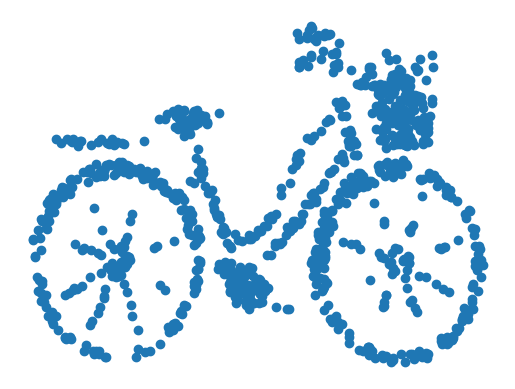

In [3]:
# wybranie losowego podzbioru 1000 indeksów
idxs = sample([i for i in range(dataset.shape[0])], 1000)

X_sample = X[idxs]
Y_sample = Y[idxs]

# przedstawienie wylosowanego podzbioru na wykresie
plt.scatter(X_sample, Y_sample)
plt.axis('off')
plt.show()

In [4]:
# początkowe wartości współczynników
T = 1000
betas = np.linspace(0.0001, 0.02, T, dtype=np.float64)

# obliczanie współczynników alfa i alfa "z kreską"
alphas = 1 - betas
alphas_bar = alphas
alphas_bar = np.cumprod(alphas)

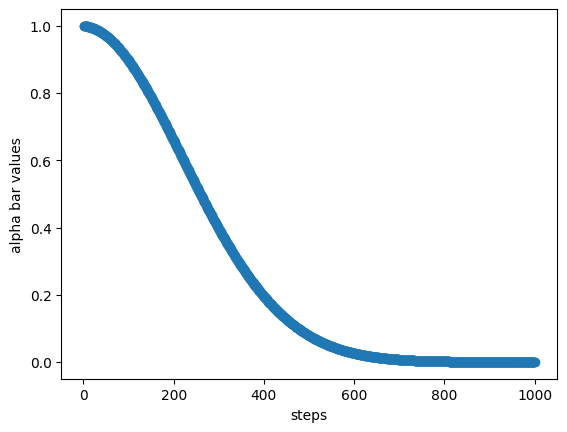

In [5]:
# prześledźmy zmianę współczynników alfa z kolejnymi krokami
t_values = np.arange(1, T+1)

plt.scatter(t_values, alphas_bar)
plt.xlabel("steps")
plt.ylabel("alpha bar values")
plt.show()

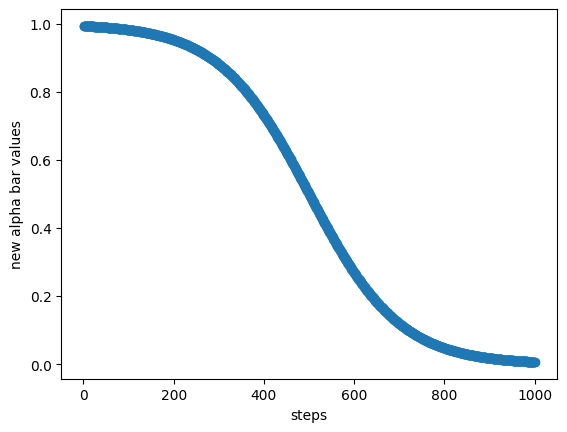

In [6]:
# funkcja sigmoidalna
def alpha_bar(t, T):
    return 1 / (1 + np.e ** (10 / T * t - 5))


new_alphas_bar = [alpha_bar(t, T) for t in t_values]

plt.scatter(t_values, new_alphas_bar)
plt.xlabel("steps")
plt.ylabel("new alpha bar values")
plt.show()

In [7]:
# obliczanie nowych współczynników alfa i beta
new_alphas = np.zeros_like(new_alphas_bar)
new_alphas[0] = new_alphas_bar[0]

for t in range(1, T):
    new_alphas[t] = new_alphas_bar[t] / new_alphas_bar[t-1]

new_betas = 1 - new_alphas

# przekształcenie ciągów w tensory
tf_alphas_bar = tf.constant(new_alphas_bar, dtype=tf.float32)
tf_alphas = tf.constant(new_alphas, dtype=tf.float32)
tf_betas = tf.constant(new_betas, dtype=tf.float32)

In [8]:
# funkcja obliczająca efekt dyfuzji dla kroku t
def diffusion(x_0, t):
    # wylosowanie epsilona z odpowiedniego rozkładu
    epsilon = tf.random.normal(shape=x_0.shape, dtype=tf.float32)

    # pobranie współczynników i konwersja do odpowiednich wymiarów
    alpha_bar_t = tf.gather(tf_alphas_bar, t-1) 
    alpha_bar_t = tf.expand_dims(alpha_bar_t, axis=-1)

    x_t = tf.sqrt(alpha_bar_t) * x_0 + tf.sqrt(1.0 - alpha_bar_t) * epsilon

    return x_t, epsilon

In [9]:
# funkcja rysująca położenie dla kolejnych etapów dyfuzji
def plot_diffusion(x_0, diffusion):
    plt.scatter(x_0[0], x_0[1], marker='$0$')

    for t, diff in enumerate(diffusion):
        plt.scatter(diff[0], diff[1], marker=f'${t+1}$')
    
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.show()

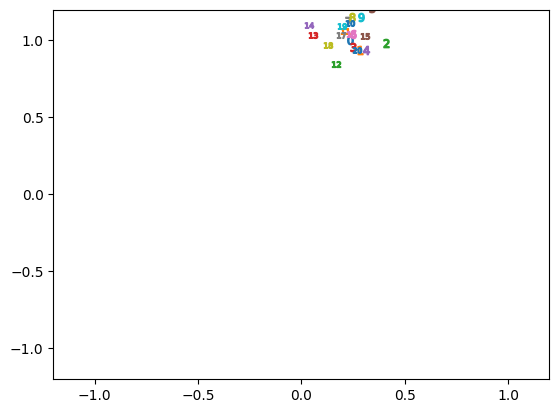

In [10]:
# sprawdźmy dyfuzję dla paru punktów ze zbioru
x_0 = tf.constant(dataset[[0 for _ in range(20)]], dtype=tf.float32)
t_sample = tf.range(1, 21, dtype=tf.int32)
diffs, _ = diffusion(x_0, t_sample)

# wyświetlmy rezultat początkowych kroków dyfuzji
plot_diffusion(x_0[0], diffs)

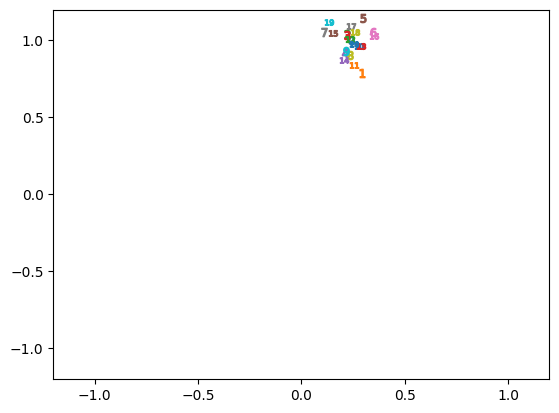

In [11]:
x_0 = tf.constant(dataset[[1 for _ in range(20)]], dtype=tf.float32)
diffs, _ = diffusion(x_0, t_sample)
plot_diffusion(x_0[0], diffs)

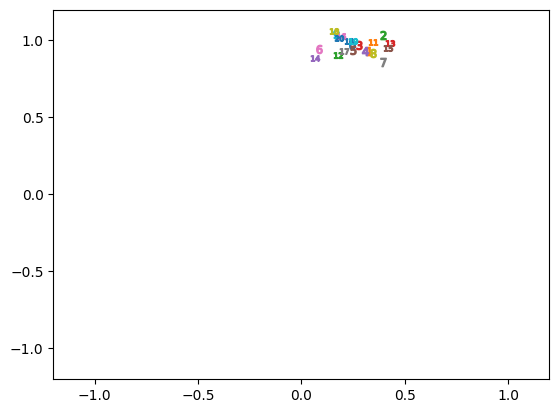

In [12]:
x_0 = tf.constant(dataset[[100 for _ in range(20)]], dtype=tf.float32)
diffs, _ = diffusion(x_0, t_sample)
plot_diffusion(x_0[0], diffs)

In [13]:
# pomocnicze zdefiniowanie bloku
class LearnableSinusoidalEmbedding(layers.Layer):
    def __init__(self):
        super(LearnableSinusoidalEmbedding, self).__init__()

        self.d = 50
        self.dense1 = layers.Dense(128, activation="relu")
        self.dense2 = layers.Dense(128)


    def call(self, t):
        d_range = tf.range(self.d, dtype=tf.float32)
        div_term = tf.math.pow(10000.0, 2 * (d_range // 2) / self.d)
        t = tf.cast(t, tf.float32)
        
        # kodowanie pozycyjne
        pe = tf.expand_dims(t, -1) * tf.expand_dims(div_term, 0)
        sin_pe = tf.sin(pe[:, 0::2])
        cos_pe = tf.cos(pe[:, 1::2])
        pe = tf.concat([sin_pe, cos_pe], axis=-1)
        
        # przepuszczenie przez warstwy FC 
        output = self.dense1(pe)
        output = self.dense2(output)
        
        return output

In [14]:
# funkcja budująca model według opisu zadania
def build_ddpm_model(embedding_layer):
    x_input = layers.Input(shape=(2,))
    time_input = layers.Input(shape=())
    
    # conditional layer 0
    x = layers.Dense(128)(x_input)
    t_emb = embedding_layer(time_input)
    output = layers.Add()([x, t_emb])
    output = layers.ReLU()(output)

    # conditional layer 1
    x = layers.Dense(128)(output)
    output = layers.Add()([x, t_emb])
    output = layers.ReLU()(output)
    
    # conditional layer 2
    x = layers.Dense(128)(output)
    output = layers.Add()([x, t_emb])
    output = layers.ReLU()(output)

    # conditional layer 3
    x = layers.Dense(128)(output)
    output = layers.Add()([x, t_emb]) 
    
    # warstwa wyjściowa modelu
    epsilon_pred = layers.Dense(2)(output)

    # stworzenie modelu i zwrócenie go
    model = models.Model(inputs=[x_input, time_input], outputs=epsilon_pred)
    
    return model

In [15]:
# hiperparametry
batch_size = 64
optimizer = optimizers.Adam(learning_rate=0.0001)
epochs = 500

# zbudowanie modelu
embedding_layer = LearnableSinusoidalEmbedding()
model = build_ddpm_model(embedding_layer)

# używana funkcja kosztu
loss_fn = losses.MeanSquaredError()

# sprawdzenie architektury modelu
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │        384 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ learnable_sinusoid… │ (None, 128)       │     23,040 │ input_layer_1[0]… │
│ (LearnableSinusoid… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128)       │          0 │ dense_2[0][0],    │
│                     │                   │            │ learnable_sinuso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128)       │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ learnable_sinuso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128)       │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ learnable_sinuso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128)       │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128)       │          0 │ dense_5[0][0],    │
│                     │                   │            │ learnable_sinuso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │        258 │ add_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,218 (286.01 KB)

 Trainable params: 73,218 (286.01 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# ścieżka do zapisywania checkpointów modelu
os.makedirs("./model_checkpoints", exist_ok=True)

start_epoch = 0

# numery epok, po których następuje zapis
epochs_save = [25, 100, 300, 500]

# zmienna do zapiywania wartości funkcji kosztu
losses = []

# korzystam z checkpointu w tensorflow
model_checkpoint = train.Checkpoint(model=model)
model_checkpoint_manager = train.CheckpointManager(
    checkpoint=model_checkpoint,
    directory="./model_checkpoints",
    max_to_keep=4
)

In [19]:
# stworzenie dataset'u, z którego można pobierać batche
tf_dataset = tf.data.Dataset.from_tensor_slices(
    dataset.astype(np.float32)
).shuffle(
    dataset.shape[0]
).batch(
    batch_size
)

In [20]:
# funkcje odpowiadające za trening modelu
def training_step(x_0):
    # wylosowanie kroków t z odpowiedniego rozkładu
    t = tf.random.uniform(shape=[x_0.shape[0]], minval=1, maxval=T+1, dtype=tf.int32)

    # obliczenie wejścia dyfuzyjnego
    x_t, epsilon = diffusion(x_0, t)

    with GradientTape() as tape:
        output = model([x_t, t], training=True)
        loss = loss_fn(epsilon, output)
        mean_loss = tf.reduce_mean(loss)

    # policzenie pochodnych po wagach
    gradients = tape.gradient(mean_loss, model.trainable_weights)

    # aktualizacja wag modelu
    optimizer.apply(gradients, model.trainable_weights)

    return mean_loss


def training():
    for epoch in range(start_epoch, epochs):
        total_loss = 0.0
        num_batches = 0

        # pętla po batchach
        for batch in tf_dataset: 
            loss = training_step(batch)
            total_loss += loss.numpy()
            num_batches += 1
            
        # zapisanie wartości funkcji kosztu
        losses.append(total_loss / num_batches)

        # wypisanie wartości funkcji kosztu co 10 epok
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(f"Średnia wartość funkcji kosztu w epoce nr {epoch + 1}: {losses[-1]:.4f}")

        # zapisanie stanu modelu
        if (epoch + 1) in epochs_save:
            model_save_path = model_checkpoint_manager.save()

            # wypisanie informacji o zapisie
            print(f"Stan modelu zapisany do {model_save_path}")

In [21]:
# algorytm generacji (odszumiania)
def sampling(animation=False):
    x_t = tf.random.normal(shape=(1000, 2))

    for t in range(T, 0, -1):
        if animation and t % 100 == 0:
            x, y = x_t[:, 0], x_t[:, 1]
            plt.scatter(x, y)
            plt.axis('off')
            plt.savefig(f"./frames/frame_{t}.png")
            plt.close()

        z = tf.random.normal(shape=x_t.shape) if t > 1 else tf.zeros_like(x_t)

        # przygotowanie wejścia czasowego
        t_input = tf.constant(t, shape=(1000,), dtype=tf.int32)
        t_input = tf.expand_dims(t_input, axis=-1)

        # deklaracje pomocniczych zmiennych
        tmp1 = 1 / tf.sqrt(tf_alphas[t-1])
        tmp2 = (1 - tf_alphas[t-1]) / tf.sqrt(1 - tf_alphas_bar[t-1])
        tmp3 = tf.sqrt(tf_betas[t-1])

        # jeden krok odszumienia
        x_t = tmp1 * (x_t - tmp2 * model([x_t, t_input], training=False)) + tmp3 * z

    return x_t

In [22]:
# funkcja do wyświetlania rezultatu odszumiania
def plot_denoised_image(x_t):
    x, y = x_t[:, 0], x_t[:, 1]
    plt.scatter(x, y)
    plt.axis('off')
    plt.show()

In [23]:
# trening modelu
training()

Średnia wartość funkcji kosztu w epoce nr 310: 0.3342
Średnia wartość funkcji kosztu w epoce nr 320: 0.3316
Średnia wartość funkcji kosztu w epoce nr 330: 0.3348
Średnia wartość funkcji kosztu w epoce nr 340: 0.3331
Średnia wartość funkcji kosztu w epoce nr 350: 0.3351
Średnia wartość funkcji kosztu w epoce nr 360: 0.3370
Średnia wartość funkcji kosztu w epoce nr 370: 0.3306
Średnia wartość funkcji kosztu w epoce nr 380: 0.3278
Średnia wartość funkcji kosztu w epoce nr 390: 0.3321
Średnia wartość funkcji kosztu w epoce nr 400: 0.3319
Średnia wartość funkcji kosztu w epoce nr 410: 0.3299
Średnia wartość funkcji kosztu w epoce nr 420: 0.3337
Średnia wartość funkcji kosztu w epoce nr 430: 0.3322
Średnia wartość funkcji kosztu w epoce nr 440: 0.3304
Średnia wartość funkcji kosztu w epoce nr 450: 0.3288
Średnia wartość funkcji kosztu w epoce nr 460: 0.3347
Średnia wartość funkcji kosztu w epoce nr 470: 0.3303
Średnia wartość funkcji kosztu w epoce nr 480: 0.3279
Średnia wartość funkcji kosz

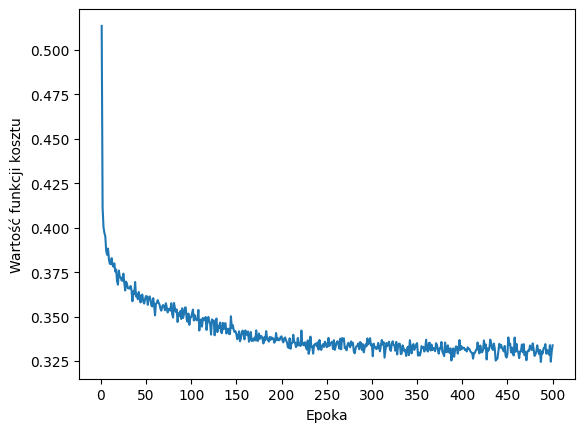

In [31]:
# narysowanie wykresu funkcji kosztu
plt.plot([i+1 for i in range(epochs)], losses)
plt.xlabel("Epoka")
plt.ylabel("Wartość funkcji kosztu")
plt.xticks([50*i for i in range(11)])
plt.show()

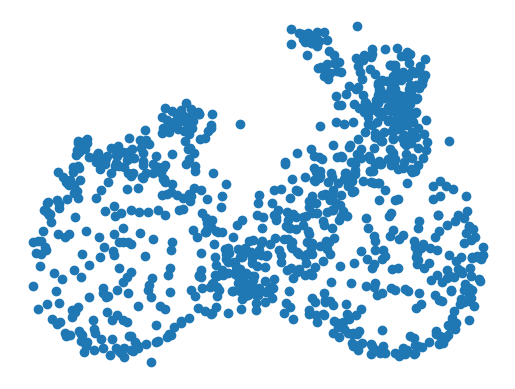

In [25]:
# ścieżka do zapisywania "animacji"
os.makedirs("./frames", exist_ok=True)

# uruchomienie procedury odszumiania
x_t = sampling(animation=True)
plot_denoised_image(x_t)

In [26]:
# funkcja wczytująca podany checkpoint i uruchamiająca procedurę odszumiania
def restore_checkpoint_and_denoise(checkpoint_no):
    # wczytanie wybranego checkpointu
    checkpoint_path = f"./model_checkpoints/ckpt-{checkpoint_no}"
    model_status = model_checkpoint.restore(checkpoint_path)

    # sprawdzenie stanu
    if model_status.expect_partial():
        print(f"Pomyślnie wczytano stan modelu z '{checkpoint_path}'")
    else:
        print(f"Nie udało się wczytać stanu modelu z '{checkpoint_path}'")

    # uruchomienie procedury odszumiania
    x_t = sampling()
    plot_denoised_image(x_t)

Pomyślnie wczytano stan modelu z './model_checkpoints/ckpt-1'


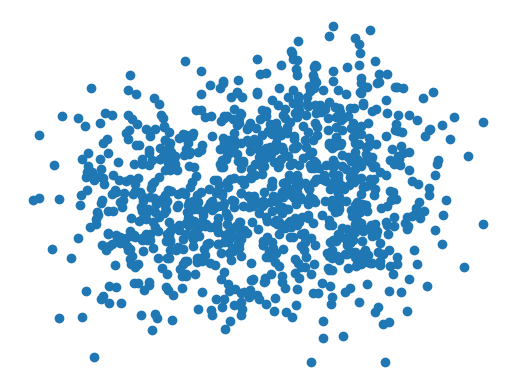

In [27]:
restore_checkpoint_and_denoise(1)

Pomyślnie wczytano stan modelu z './model_checkpoints/ckpt-2'


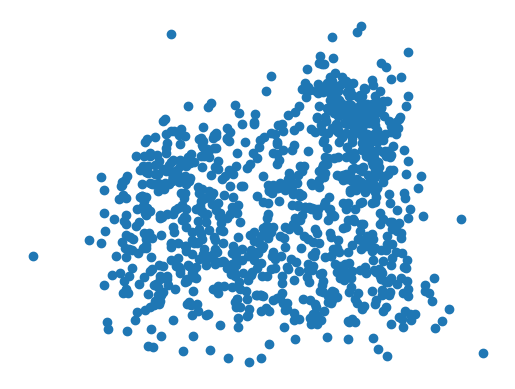

In [28]:
restore_checkpoint_and_denoise(2)

Pomyślnie wczytano stan modelu z './model_checkpoints/ckpt-3'


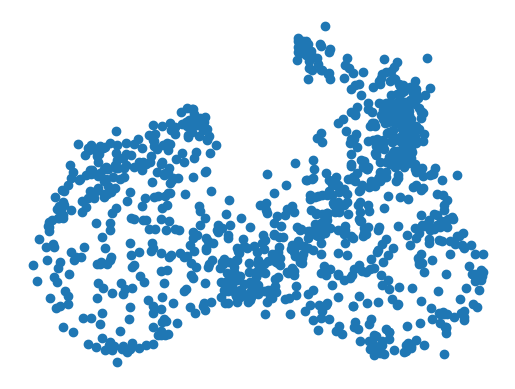

In [29]:
restore_checkpoint_and_denoise(3)

Pomyślnie wczytano stan modelu z './model_checkpoints/ckpt-4'


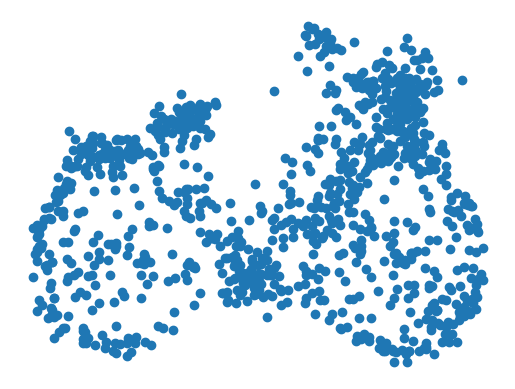

In [30]:
restore_checkpoint_and_denoise(4)